# Basic KF Kalman filter

In this notebook, we'll implement a basic Kalman Filter for a one-dimensional constant velocity model. 

We'll estimate the position and velocity of an object moving along a straight line given noisy position measurements.

The Kalman Filter is an optimal recursive data processing algorithm. It estimates the state of a dynamic system from a series of incomplete and noisy measurements.

In [87]:
import numpy as np
import matplotlib.pyplot as plt


In [88]:
#  Simulation Parameters
dt = 1.0          # Time step (seconds)
t = np.arange(0, 20 + dt, dt)  # Time vector from 0 to 20 seconds
t

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [89]:
# Constant velocity model

# Ground Truth
# True initial position and velocity
true_position = 0.0      # meters
true_velocity = 1.0      # meters/second

# Generate true position data
true_positions = true_position + true_velocity * t
true_positions

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [90]:
# Accelerating model

# # True initial position, velocity, and acceleration
# true_position = 0.0       # meters
# true_velocity = 1.0       # meters/second
# true_acceleration = 0.2   # meters/second^2

# # Generate true position and velocity data
# true_positions = true_position + true_velocity * t + 0.5 * true_acceleration * t**2
# true_velocities = true_velocity + true_acceleration * t

In [91]:
true_velocities

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
       3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

In [92]:
# Noisy Measurements
# Measurement noise standard deviation
measurement_noise_std = 2.0  # meters

# Generate noisy measurements
measurements = true_positions + np.random.normal(0, measurement_noise_std, size=t.shape)
measurements


array([-0.76894291,  0.59841623, -0.66389407,  4.97000324,  3.89361199,
        6.51015835,  9.02265913,  9.11699909,  5.20831596, 10.04764687,
        9.74304734, 10.65921215, 12.89620141, 11.71466028, 12.55011374,
       16.88522502, 15.20605268, 17.27000439, 16.0543016 , 15.69351093,
       18.75702394])

## Kalman Filter Parameters

### State transition matrix

The state transition matrix describes how the state of the system evolves from one time step to the next. In our case, the state is the position and velocity of the object. The state transition matrix is given by

Expanded:
[ position𝑘+1 ] = [1 𝑑𝑡] [position𝑘]
[ velocity𝑘+1 ]   [0 1] [velocity𝑘]

In [93]:
# State transition matrix
factor_for_current_position_to_next = 1
factor_for_current_velocity_to_next = 1
factor_for_the_position_to_the_next_velocity = 0
A = np.array(
    [
        [factor_for_current_position_to_next, dt],# dt is the time step
        [factor_for_the_position_to_the_next_velocity, factor_for_current_velocity_to_next]
    ]
)

Where the Order of the Elements Comes From
The arrangement of elements in the state transition matrix 
𝐴
A is systematic:

- Rows (Equations for Next State Variables):
    - First Row: Predicts the next position.
    - Second Row: Predicts the next velocity.
- Columns (Current State Variables):
    - First Column: Coefficients for the current position.
    - Second Column: Coefficients for the current velocity.

This layout ensures that when you perform the matrix multiplication 

### Observation matrix (H)

The order of the elements in 𝐻 corresponds to:

- Columns: Each state variable in the state vector 𝑥
    - First Column: Coefficient for position. How much the position contributes to the measurement.
    - Second Column: Coefficient for velocity. How much the velocity contributes to the measurement.

In [94]:
# Factors for the observation matrix
position_to_measurement_factor = 1
velocity_to_measurement_factor = 0

# Observation matrix
H = np.array([[position_to_measurement_factor, velocity_to_measurement_factor]])


#### Extending the Model
1. Multiple Measurements
If we have multiple sensors measuring different aspects of the state, 𝐻 would have multiple rows.

For example, if we measure both position and a noisy estimate of velocity:

```python
# Observation matrix for measuring both position and velocity
H = np.array([
    [1, 0],  # Position measurement equation
    [0, 1]   # Velocity measurement equation
])
```

2. Nonlinear Measurements

For nonlinear relationships between the state and measurements, we would need to use the Extended Kalman Filter (EKF) and linearize the measurement function.

## Process Noise Covariance Matrix 𝑄 Explained


Process noise represents the random fluctuations or uncertainties in the system's evolution that are not captured by the deterministic model

1. Role of 𝑄 in the Kalman Filter

In the Kalman Filter, the process noise covariance matrix 𝑄 represents the uncertainty in the system model

In [95]:
process_noise_std = 1e-5 # How much the model is trusted
print(f"{process_noise_std:.6f}")

0.000010


In [96]:
# Variance of acceleration noise
variance_acceleration_noise = process_noise_std ** 2  # σ_a^2
variance_acceleration_noise

1.0000000000000002e-10

In [97]:
# Compute elements of Q
position_variance = variance_acceleration_noise * (dt ** 4) / 4
position_variance # Accumulated uncertainty in position due to acceleration over time

2.5000000000000004e-11

In [98]:
position_velocity_covariance = variance_acceleration_noise * (dt ** 3) / 2
position_velocity_covariance # Represents the correlation between errors in position and velocity due to acceleration.

5.000000000000001e-11

In [99]:
velocity_variance = variance_acceleration_noise * dt ** 2
velocity_variance # Uncertainty in velocity due to acceleration over time 

1.0000000000000002e-10

In [100]:
# Construct Q using descriptive variable names
Q = np.array([
    [position_variance, position_velocity_covariance],
    [position_velocity_covariance, velocity_variance]
])
Q

array([[2.5e-11, 5.0e-11],
       [5.0e-11, 1.0e-10]])

## Measurement Noise Covariance Matrix 𝑅 Explained

1. Role of 𝑅 in the Kalman Filter

In the Kalman Filter, the measurement update step incorporates new measurements to refine the state estimates. The measurement noise covariance matrix 𝑅 represents the uncertainty associated with the measurements.

In [101]:
measurement_noise_variance = measurement_noise_std ** 2
measurement_noise_variance

4.0

In [102]:
# Measurement noise covariance
R = np.array([[measurement_noise_variance]])
R

array([[4.]])

In [103]:
# Initial state estimate
x_est = np.array([[0],
                  [0]])  # Start with zero position and velocity
x_est

array([[0],
       [0]])

In [104]:
# Initial covariance estimate
P = np.eye(2) * 500  # Large initial uncertainty
P

array([[500.,   0.],
       [  0., 500.]])

## Storage for estimates

In [105]:
# Lists to store estimates
estimated_positions = []
estimated_velocities = []
position_uncertainties = []
velocity_uncertainties = []
kalman_gains = []


## Kalman Filter Algorithm

In [106]:
for idx in range(len(t)):
    print(f"Time step {idx}")
    # Prediction Step
    x_pred = A @ x_est # State prediction with the state transition matrix and the previous state estimate
    print("Next state prediction:", x_pred)
    P_pred = A @ P @ A.T + Q # Covariance prediction with the state transition matrix, the previous covariance estimate, and the process noise covariance
    print("Next covariance prediction:", P_pred)
    # Measurement Update Step
    z = measurements[idx] # Current measurement
    print("Current measurement:", z)
    y = z - (H @ x_pred)  # Measurement residual, we compare the measurement with the prediction and the observation matrix
    print("Measurement residual:", y)
    S = H @ P_pred @ H.T + R  # Residual covariance is the prediction uncertainty combined with the measurement noise covariance
    print("Residual covariance:", S)
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain is the proportion of the prediction uncertainty to the residual covariance
    print("Kalman gain:", K)
    x_est = x_pred + K @ y # State estimate update, by combining the prediction with the measurement by the Kalman gain proportion
    print("State estimate update:", x_est)
    P = (np.eye(2) - K @ H) @ P_pred 
    print("Covariance estimate update:", P)
    # Store estimates and uncertainties
    estimated_positions.append(x_est[0, 0])
    estimated_velocities.append(x_est[1, 0])
    position_uncertainties.append(P[0, 0])
    velocity_uncertainties.append(P[1, 1])
    # Store the Kalman Gain (position component)
    kalman_gains.append(K[0, 0])


Time step 0
Next state prediction: [[0.]
 [0.]]
Next covariance prediction: [[1000.  500.]
 [ 500.  500.]]
Current measurement: -0.7689429061446199
Measurement residual: [[-0.76894291]]
Residual covariance: [[1004.]]
Kalman gain: [[0.99601594]
 [0.49800797]]
State estimate update: [[-0.76587939]
 [-0.38293969]]
Covariance estimate update: [[  3.98406375   1.99203187]
 [  1.99203187 250.99601594]]
Time step 1
Next state prediction: [[-1.14881908]
 [-0.38293969]]
Next covariance prediction: [[258.96414343 252.98804781]
 [252.98804781 250.99601594]]
Current measurement: 0.5984162303782925
Measurement residual: [[1.74723531]]
Residual covariance: [[262.96414343]]
Kalman gain: [[0.9847888 ]
 [0.96206291]]
State estimate update: [[0.57183869]
 [1.29801059]]
Covariance estimate update: [[3.9391552  3.84825162]
 [3.84825162 7.60559966]]
Time step 2
Next state prediction: [[1.86984927]
 [1.29801059]]
Next covariance prediction: [[19.24125811 11.45385128]
 [11.45385128  7.60559966]]
Current meas

In [107]:
estimated_positions

[np.float64(-0.7658793885902591),
 np.float64(0.571838685767114),
 np.float64(-0.22781727060876755),
 np.float64(3.411625997436403),
 np.float64(4.335068148658645),
 np.float64(6.122424748762835),
 np.float64(8.25980972344896),
 np.float64(9.568272872987345),
 np.float64(8.898019083419223),
 np.float64(10.06211016557669),
 np.float64(10.759082843172912),
 np.float64(11.50761837569761),
 np.float64(12.655458080152194),
 np.float64(13.207000014112287),
 np.float64(13.814684048419695),
 np.float64(15.262230591184775),
 np.float64(16.04634281978893),
 np.float64(17.087370356690876),
 np.float64(17.690094153953243),
 np.float64(18.106173358116433),
 np.float64(18.981509885449196)]

In [108]:
estimated_velocities

[np.float64(-0.38293969429515823),
 np.float64(1.2980105873886472),
 np.float64(0.049320896764756705),
 np.float64(1.581268982785132),
 np.float64(1.3626321518372662),
 np.float64(1.4782147165504402),
 np.float64(1.630069081528876),
 np.float64(1.5658394424758209),
 np.float64(1.1717129319845878),
 np.float64(1.170510750832765),
 np.float64(1.1029255501264814),
 np.float64(1.056739410313801),
 np.float64(1.0676631658418931),
 np.float64(1.010356057268951),
 np.float64(0.9687268771800147),
 np.float64(1.0150369061239812),
 np.float64(0.9940552985461353),
 np.float64(0.9980794183588332),
 np.float64(0.966039059120959),
 np.float64(0.9237537485416669),
 np.float64(0.9202125537102651)]

In [109]:
position_uncertainties

[np.float64(3.984063745019794),
 np.float64(3.9391552027150167),
 np.float64(3.3115691101021105),
 np.float64(2.789257176782793),
 np.float64(2.3936578210666464),
 np.float64(2.091059088825126),
 np.float64(1.8541804345281143),
 np.float64(1.6644552898188327),
 np.float64(1.50939593398674),
 np.float64(1.380448116405564),
 np.float64(1.271607068327221),
 np.float64(1.1785537910387824),
 np.float64(1.0981111180360459),
 np.float64(1.0278939769186743),
 np.float64(0.9660791696376889),
 np.float64(0.9112502708078336),
 np.float64(0.8622908280520861),
 np.float64(0.8183093259210217),
 np.float64(0.7785854855342155),
 np.float64(0.7425311810341431),
 np.float64(0.7096615538007753)]

In [110]:
velocity_uncertainties

[np.float64(250.99601593631132),
 np.float64(7.605599660653553),
 np.float64(1.9608661188002046),
 np.float64(0.7908420179628499),
 np.float64(0.39682992491692326),
 np.float64(0.22719695845756363),
 np.float64(0.1421673578067778),
 np.float64(0.09485452600297517),
 np.float64(0.06643655025284938),
 np.float64(0.048338481903530225),
 np.float64(0.03626611690558713),
 np.float64(0.027904554996082458),
 np.float64(0.02192985398018077),
 np.float64(0.01754711226117623),
 np.float64(0.014259247234054463),
 np.float64(0.0117444744588685),
 np.float64(0.009788191587234592),
 np.float64(0.00824351945369452),
 np.float64(0.007007615054594769),
 np.float64(0.006007002027609358),
 np.float64(0.005188232157331371)]

## Plot the results

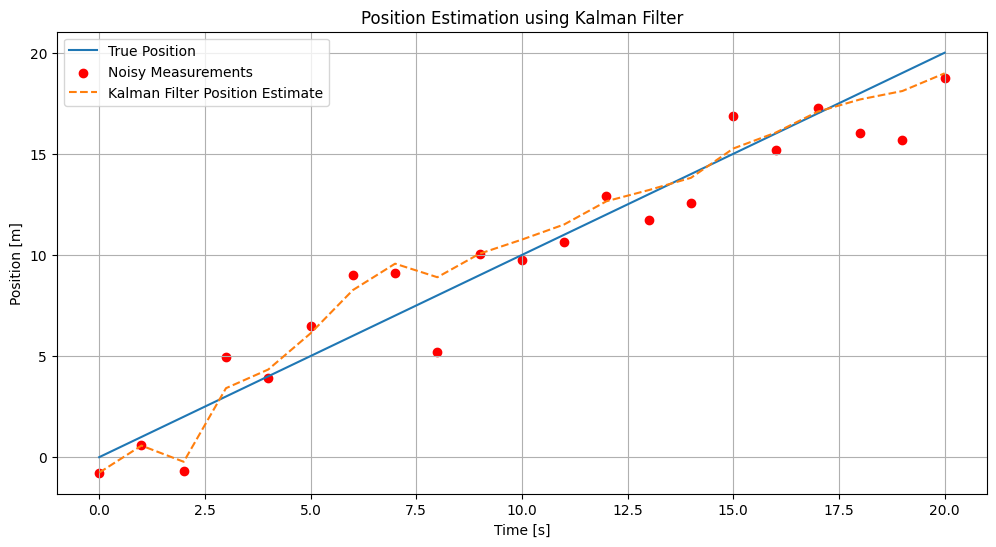

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(t, true_positions, label='True Position')
plt.scatter(t, measurements, color='red', label='Noisy Measurements', marker='o')
plt.plot(t, estimated_positions, label='Kalman Filter Position Estimate', linestyle='--')
plt.title('Position Estimation using Kalman Filter')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.grid(True)
plt.show()


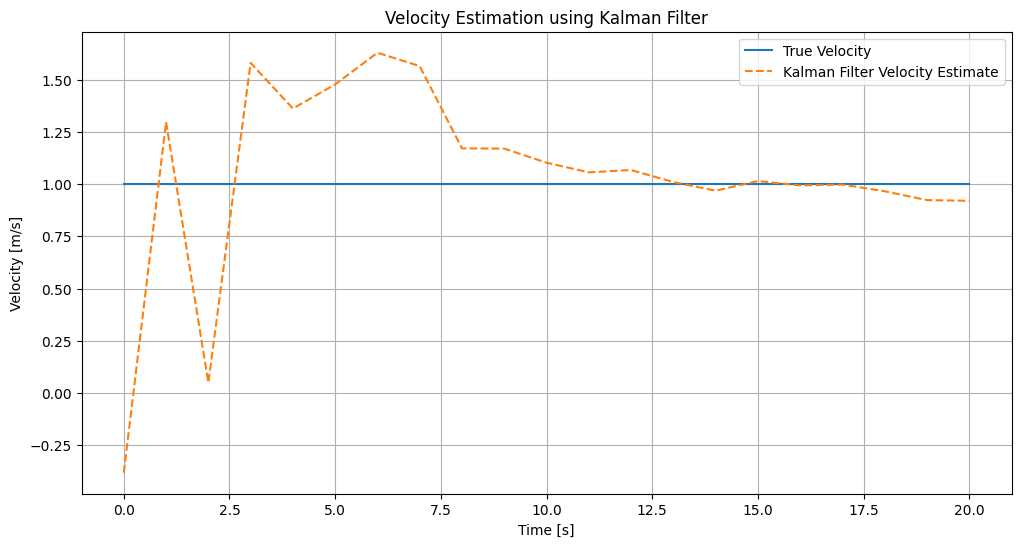

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(t, [true_velocity]*len(t), label='True Velocity')
plt.plot(t, estimated_velocities, label='Kalman Filter Velocity Estimate', linestyle='--')
plt.title('Velocity Estimation using Kalman Filter')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.show()


for idx in range(len(t)):
    # Prediction Step
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q

    # Measurement Update Step
    z = measurements[idx]
    y = z - (H @ x_pred)  # Measurement residual
    S = H @ P_pred @ H.T + R  # Residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain

    x_est = x_pred + K @ y
    P = (np.eye(2) - K @ H) @ P_pred

    # Store estimates and uncertainties
    estimated_positions.append(x_est[0, 0])
    estimated_velocities.append(x_est[1, 0])
    position_uncertainties.append(P[0, 0])
    velocity_uncertainties.append(P[1, 1])


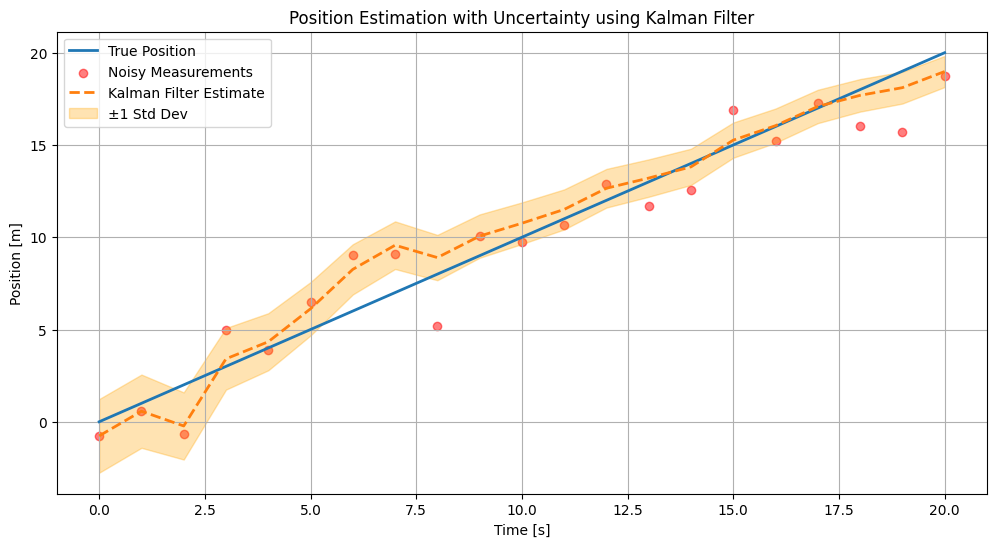

In [113]:
# Convert variances to standard deviations
position_std_devs = np.sqrt(position_uncertainties)
velocity_std_devs = np.sqrt(velocity_uncertainties)

# Plotting Position Estimates with Uncertainty
plt.figure(figsize=(12, 6))
plt.plot(t, true_positions, label='True Position', linewidth=2)
plt.scatter(t, measurements, color='red', label='Noisy Measurements', marker='o', alpha=0.5)
plt.plot(t, estimated_positions, label='Kalman Filter Estimate', linestyle='--', linewidth=2)
upper_bound = np.array(estimated_positions) + position_std_devs
lower_bound = np.array(estimated_positions) - position_std_devs
plt.fill_between(t, lower_bound, upper_bound, color='orange', alpha=0.3, label='±1 Std Dev')
plt.title('Position Estimation with Uncertainty using Kalman Filter')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.grid(True)
plt.show()



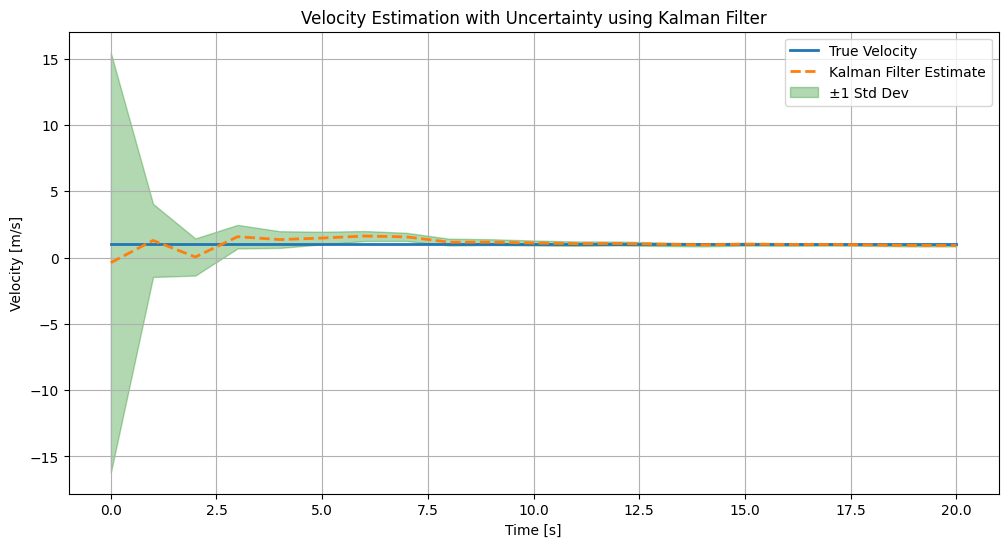

In [114]:
# Plotting Velocity Estimates with Uncertainty
plt.figure(figsize=(12, 6))
plt.plot(t, [true_velocity]*len(t), label='True Velocity', linewidth=2)
plt.plot(t, estimated_velocities, label='Kalman Filter Estimate', linestyle='--', linewidth=2)
upper_bound_vel = np.array(estimated_velocities) + velocity_std_devs
lower_bound_vel = np.array(estimated_velocities) - velocity_std_devs
plt.fill_between(t, lower_bound_vel, upper_bound_vel, color='green', alpha=0.3, label='±1 Std Dev')
plt.title('Velocity Estimation with Uncertainty using Kalman Filter')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.show()


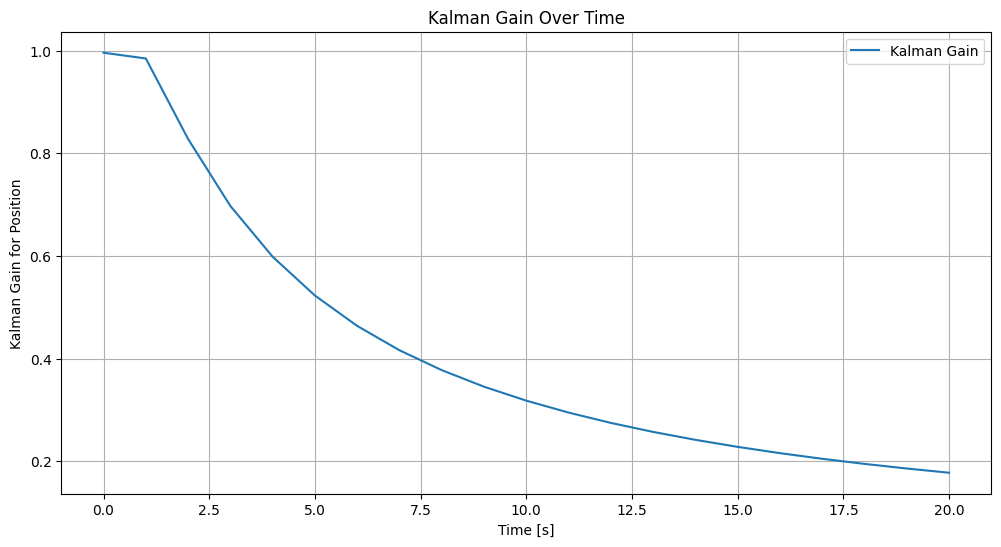

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(t, kalman_gains, label='Kalman Gain')
plt.title('Kalman Gain Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Kalman Gain for Position')
plt.legend()
plt.grid(True)
plt.show()
